<a href="https://colab.research.google.com/github/Wizzzzzzard/Wizzzzzzard/blob/main/Binary_Classification_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Task 1 Relevance Modelling:** Predict the relevance of documents given search interaction features.

Class: CS987

Group: AE

 - Andrea Oteo: 202059017
 - Ane Etxeandia Erauskin:
 - Crawford Middleton:
 - Daragh McCarthy: 202075755
 - Elijah Reid: 202093659

# Overview and Abstract
**Briefly describe what you did**

- We began by exploring the data to see what values seemed likely to have an effect on whether the document was classified as relevant or not. Following this, we dropped the variables that we deemed as irrelevant and then used one-hot encoding to transform the categorical variables into numerical ones so they could be better understood by our algorithms. After this we split the data into training, validation and test sets using sci-learn train_test_split before scaling the data to give it a mean of 0 and standard deviation of 1.

- We fed this into a standard machine learning model (random forest classifier) but due the highly skewed nature of the data (relevant documents make up only ~6% of the entire dataset) the performance was not great **[fill in scores]**.

- To alleviate this we created a three-layer neural network as a baseline and experimented with various techniques to overcome the imbalance. This included oversampling, undersampling, ensemble methods, SMOTE, setting the initial bias and class weights to see which would deliver the best performance. 

- We also performed data augmentation on the cpvs column to both increase the number of features and rows. We exploded the list to increase length, and then shortened the code to the first two numbers to represent 'division' before one-hot encoding it.

- In the end, the method that gave the best performance was adjusting the class weights to better fit the data, so we decided to move forward using the class weights of the three layer model for our next two models.

- We created a neural network with several more layers than the initial baseline to see if a deeper network would perform better than a shallow one. This turned out to be...

- Finally we created a wide and deep network, splitting the inputs into a relevant and irrelevant training set so the network could better learn how to distinguish between the two and hopefuly improve it's classification performance. Ultimately the model's performance was...



# Method

### Import Modules

In [1]:
# Include your packages/imports here.
!pip install -q pyyaml h5py

from google.colab import drive

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import seaborn as sns
import math

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve,roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.callbacks import Callback
from keras.utils import normalize, to_categorical
from keras.wrappers.scikit_learn import KerasClassifier


from ast import literal_eval
from functools import partial

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Describe the data processing, feature extraction, etc. performed (and why it was performed) 

After the data was loaded in, we began by dropping columns that contained too many unique values. This was because our approach was to one-hot encode categorical variables and if we had encoded these variables the model would have ended up overfitting on the training set due to the large number of variables.

While we initially considered dropping the CPVs column for the above reasons, we instead shortened the code to it’s first two digits (this refers to the code’s division category) to reduce the number of unique variations in the dataset and then encoded this column as well.


## Describe the baseline model to be used (and why it was selected)

The standard machine learning base line algorithm we have selected is the random forest model. Random forest algorithm is an emsemble of decision trees, which is trained using the technique of bagging. 

During training the model is focused on selecting the best features instead of instances. The algorithm selects the best features from a random subset of features. 

The model is appropriate for several reasons:
 - the algortihm has high bias/low variance. This is ideal for the dataset as it has a large number of observations compared to the number of features.  
 - it allows us to analyse feature importance by describing the most applicable features to impact a user assessing a document as relevant or not.

## Describe each neural model configuration / setup that will be used.
The model’s we have decided to include are the following:
-	Three Layer MLP model
-	Dense Deep Model (ultimately 6 layers were selected)
-	A Wide and Deep Model as we believed this may have helped to reduce the effect of the bias towards irrelevant documents featured in the data (more on this below)

Other models were trialled, including a Deep Belief Network and a Natural Language Model but ultimately, they performed worse both in terms of their f1 score and the time needed to train them.

## Describe the training schedule and approach that you undertook.

While training we used several methods to improve the models performance and limit it from overfitting.


We created a custom dense layer to use, which made use of:
- the ELU activation function (This is slower to compute than the standard RELU function, but it makes up for it by tending to converge faster during training)
- the He initialiser (this initialisation method is optimised for ReLU variations)
- l2 regularisation (this helps constrain the neural network’s connection weights and limits overfitting)

When creating our models, we added both batch normalisation and drop out layers:
- Batch normalisation works with the He initialiser and ELU to ensure that the vanishing/exploding gradient problem does not occur by normalising and zero-centring each input and then scaling and shifting the result based on this.
- The drop out layer works by giving each neuron a random chance to be dropped out at each training step, helping to prevent overreliance on specific connections and decreasing the error rate in validation. 


We decided to use the Nadam optimiser because it is an adaptive optimiser- it combines the Adam optimiser (which is already able to keep track of an exponentially decaying average of past gradient like momentum optimisation, and can keep track of past squared gradients like RMSProp) with the Nesterov trick, allowing it to run slightly faster than the standard Adam optimiser.

Finally, the Learning Rate Scheduler we used was 1cycle scheduling. Unlike most other approaches it increases the learning rate linearly up to halfway through training and then decreases it in the second half, dropping down several orders of magnitude in the last few epochs. We selected it as it has been shown to produce similar validation accuracy results to other methods, but in a far shorter time span.


## Define the functions that will help you to perform the training schedule

In [2]:
# Create Dense layer with built in selu function and appropriate regularisation
RegularizedDense = partial(keras.layers.Dense, 
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l1_l2(0.01))

# Sets up all the metrics that allow for the f1_score to be calculated
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Implement early stopping to help limit overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Custom One Cycle Learning Scheduler for use with models
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

## Describe any other things that you did or tried in order to improve performance

As the dataset was heavily skewed towards results that were irrelevant (there were only 1962 values for 1 out of 33000 total records - only 5.95% of the total)

To try and alleviate this we used several methods and compared their performance. These are as follows:
-	We adjusted the biases of the model to try and prevent the model from overfitting on the irrelevant documents (0) and to focus more on the relevant documents (1) to compensate for the vastly different amounts of each. This only applies to the output step however which is less than ideal.

-	This did have some effect on the number of false positives, however it led to more false negatives, so we instead decided to adjust the class weights directly. This causes the model to “pay more attention” to examples from an under-represented class” during the training process.

-	As a final option we used SMOTE to resample the dataset and oversample the minority class. This means that no adjustments need to be made to the actual model and should improve its ability to recognise what a relevant document looks like.

After trying all 3 methods with our three-layer neural network, both the re-weighted and resampled models performed significantly better than with the models trained on the original data so we continued to use these methods for the dense deep network.

### Set-up functions

In [3]:
# Add your functions for training here

# one hot encodes categorical variables to allow them to be used in neural network training
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[feature_to_encode])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

# Function to display mean and standard deviation of scores for standard machine learning model
def display_scores(scores):
    print("\nScores:",scores)
    print("\nMean:",scores.mean())
    print("\nStandard Deviation:",scores.std())

# Function to create confusion matrices with various statistics and scores
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print('f1 Score', (cm[1][1]/(cm[1][1] + (0.5*(cm[0][1] + cm[1][0])))))
  print()

  print('Irrelevant Documents Detected (True Negatives): ', cm[0][0])
  print('Irrelevant Documents Incorrectly Detected (False Positives): ', cm[0][1])
  print('Relevant Documents Missed (False Negatives): ', cm[1][0])
  print('Relevant Documents Detected (True Positives): ', cm[1][1])
  print('Total Relevant Documents: ', np.sum(cm[1]))
 
# Function to compare loss performance of two models
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

# Function to produce plots of metrics for model training
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Function for producing an ROC plot to determine precision and recall of model
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

### Models

#### Final Random Forest Model (Baseline)

https://colab.research.google.com/drive/1boa4ZFjmB7C0jcKh6fugi14CXfhQ-xTP#scrollTo=5hh8XlLyN36C&line=7&uniqifier=1

#### Three Layer Model Function

https://colab.research.google.com/drive/1boa4ZFjmB7C0jcKh6fugi14CXfhQ-xTP#scrollTo=A88mkimt0IDN&line=11&uniqifier=1

#### Dense Deep Model Function

https://colab.research.google.com/drive/1boa4ZFjmB7C0jcKh6fugi14CXfhQ-xTP#scrollTo=_yMzpAIBxXHB&line=6&uniqifier=1

#### Wide and Deep Model Class

https://colab.research.google.com/drive/1boa4ZFjmB7C0jcKh6fugi14CXfhQ-xTP#scrollTo=Nky1aIvoWBwt&line=6&uniqifier=1

# Results and Discussion




Model Scores on validation data, loss has been set to 0 for random forests due to the difference of their architectures

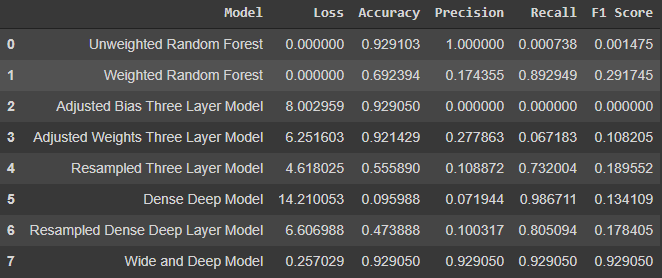

Graph of each model's train and test performance, comparing percentage of true positives to percentage of false positivies

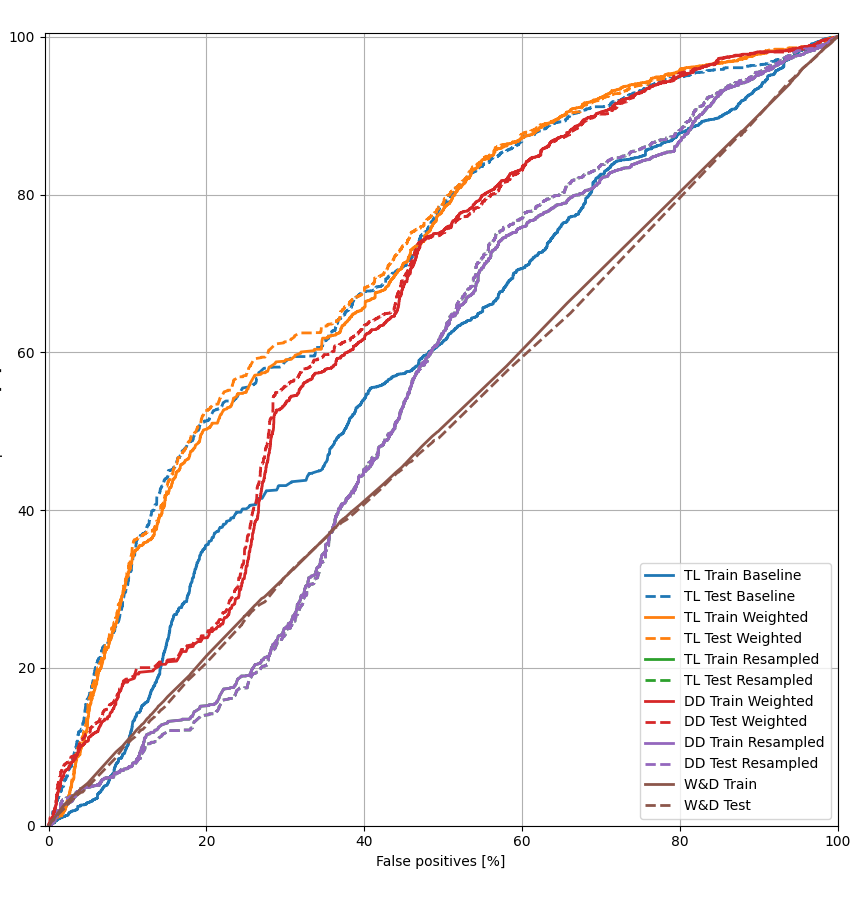

The model that performed the best was the resampled dense deep network, with an f1 score on the test set of (0.10633). However this is only mildly better than the three layer models trained with adjusted class weights and resampled data which score (0.09920) and (0.09267) respectively. 

Contrary to our expectations the wide and deep model actually performed the worst as even with a limited epoch run it would very quickly overfit the data and predict all documents as being irrelevant, which scored very well on the skewed training set but poorly on the test set as a result.

Unfortunately even with the methods we've used to try and improve the model's ability to recognise relevant documents, even our best performing model was only able to achieve an F1 score of (0.10633). 

# Summary and Recommendations

Based off our results we would recommend that the company should go with our three layer model, as it was the most able to generalise and predict accurately on the test data. The deep dense network also shows promise, and with more in-depth tuning it seems likely that it would be able to outperform the three layer model.

However it still has a lacklustre performance compared to models used for skewed datasets (for instance in credit card fraud detection) and so we would recommend that the company should gather more data points for relevant documents and use these for training their model. Using an embedding layer to include more of the categorical data, and the associations between them would also probably yield better performances.

Alternatively they could train a Generative Adverserial network on the dataset, which would allow them to generate new datapoints and massively improve the performance on the dataset. A Natural Language Model might also be able to perform better on the dataset by reading in the data in text form and converting the cvps codes into their text descriptions.

# References

- Aurélien Géron (September 2019) *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition edn.*, US: O'Reilly Media, Inc.
- TensorFlow (2020) *Classification on imbalanced data*, Available at: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
- Andrej Karpathy (2019) *A Recipe for Training Neural Networks*, Available at: http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines
- Leslie N. Smith (2018) A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay
- Nitish Srivastava et al (2014) 'Dropout: A Simple Way to Prevent Neural Networks from Overfitting', Journal of Machine Learning Research, 15(), pp. 1929-1958.

# Code

## Feature Processing


### Load in dataset from Githhub


In [8]:
train_url = "https://raw.githubusercontent.com/Wizzzzzzard/Wizzzzzzard/main/CS987/Binary%20Data/train.csv"
test_url = "https://raw.githubusercontent.com/Wizzzzzzard/Wizzzzzzard/main/CS987/Binary%20Data/test.csv"

In [9]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data processing and exploration

In [10]:
train.head()

,user,session,query,timestamp,search,rank,serp,hour,day,month,dwell,new-sub,premium-pack,psrel,source,type,nature,cpvs,#cpv45
0,8438057,A311E564F0A79803FB564CEAB6D7499A,d4fe169251f77f0800245e2df8376856,2020-05-26 10:45:36,quick,1,1,10,Tue,May,1,1,0,0,Intercon,notice,services,"['66131100', '66141000', '66519600', '66520000']",1
1,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:47:51,saved,75,8,10,Tue,Jan,10,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
2,922102585,7D717BA805FB42D51D6C8EC15C0DE2C1,174e0e6c62fd5d7b044dd05b47ce79c9,2020-02-05 09:37:42,advanced,4,1,9,Wed,Feb,21,1,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
3,2105483652,D4855E55686DB80328B141598E3174CE,0f9f7f67dc569a6e3dba1ef35ce8970a,2020-01-21 14:43:57,advanced,66,4,14,Tue,Jan,21,0,0,0,Contrax Weekly,notice,services,"['79421000', '92520000', '92521000']",2
4,8438876,5E91CF19B8BEBA58A90E54EC97AAB3AF,5066bca0a00273cf3925b0c2f260f763,2020-01-21 10:48:33,saved,81,9,10,Tue,Jan,20,1,0,0,Contrax Weekly,notice,services,"['72000000', '72263000', '72300000']",1


In [11]:
test.head()

,user,session,query,timestamp,search,rank,serp,hour,day,month,dwell,new-sub,premium-pack,source,type,nature,cpvs,#cpv45,Id
0,2096178939,3C5FDDE0DBC2E5E812A8DFFAB3491DAA,c71cdfc115f151060c9671fc816cff25,2020-01-21 12:34:56,advanced,2,1,12,Tue,Jan,122,0,0,Contrax Weekly,notice,services,['73110000'],1,0
1,2096178939,B9D21C26929EF384ABBB6B544FB38858,c71cdfc115f151060c9671fc816cff25,2020-01-21 17:33:56,advanced,8,1,17,Tue,Jan,8,0,0,Project,award,services,['79311000'],1,1
2,2096178939,B9D21C26929EF384ABBB6B544FB38858,c71cdfc115f151060c9671fc816cff25,2020-01-21 17:34:04,advanced,7,1,17,Tue,Jan,26,0,0,PCS,notice,services,['73110000'],1,2
3,2096178939,B9D21C26929EF384ABBB6B544FB38858,c71cdfc115f151060c9671fc816cff25,2020-01-21 17:34:36,advanced,3,1,17,Tue,Jan,6,0,0,Contrax Weekly,notice,services,"['73110000', '85100000']",2,3
4,2096178939,71182AF6B9BCB557CFA9402F6CD97361,c5b7b023e9c78c403d621025a715a95c,2020-01-22 09:34:49,advanced,1,1,9,Wed,Jan,1531,0,0,Contracts Finder,award,services,['79310000'],1,4


In [12]:
# Examine the class label imbalance

neg, pos = np.bincount(train['psrel'])
total = neg + pos
print('Examples:\n    Total: {}\n    Ones: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 33000
    Ones: 1962 (5.95% of total)



### Clean, split and normalize the data

The raw data has a few issues. First the Time columns as well as the  `user`, `session` and `query` columns are too variable to use directly. Drop the Time and other columns (since it's not clear how they would relate to the relevancy in this context) and drop the #`cpvs45` column to remove the colinearity between it and `cpvs`

In [13]:
cleaned_df = train.copy()

# drop variables
cleaned_df = cleaned_df.drop(["user","session","query", "timestamp", "#cpv45", "day", "hour","month"], axis=1)
test = test.drop(["user","session","query", "timestamp", "#cpv45", "day", "hour","month","Id"], axis=1)

In [14]:
# augment cpvs - train - lengthened and widened
cleaned_df['cpvs'] = cleaned_df['cpvs'].apply(literal_eval) #convert to list type

# explode cpvs list to lengthen dataset
cleaned_df = cleaned_df.explode('cpvs')

# shorten cpvs column to first two numbers which represent division category
cleaned_df['division'] = cleaned_df['cpvs'].astype(str).str[:2]
cleaned_df = cleaned_df.drop("cpvs", axis=1) #drop new column

# augment cpvs - test - only widened - keep 5000 rows
test['cpvs'] = test['cpvs'].apply(literal_eval) #convert to list type
test["cpv_new"] = test["cpvs"].str[0] #copy first entry from each list
test = test.drop("cpvs", axis=1) #drop original column

test["division"] = test['cpv_new'].astype(str).str[:2]
test = test.drop("cpv_new", axis=1) #drop new column column

In [15]:
# One-hot encode the categorical variables that seem like they may have an effect on the relevancy of the document found

features_to_encode = ['search', 'source', 'type', 'nature', 'division']

for feature in features_to_encode:
    cleaned_df = encode_and_bind(cleaned_df, feature)

for feature in features_to_encode:
    test = encode_and_bind(test, feature) 

## Training and Validating etc.
- Show your working here – where you report all your training and validation, etc. that you performed in order to get the results.
- Note that it is important that you results can be replicated. All code to reproduce the final predictions must be included, along with any code that justifies your choices.



Split the dataset into train, validation, and test sets. 

 - The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. 

 - The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. 
 
This is especially important in our case due to the imbalanced dataset as [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [16]:
# Use sklearn train_test_split to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_wide_and_deep_df, test_wide_and_deep_df = train_test_split(cleaned_df, test_size=0.2)
train_wide_and_deep_df, val_wide_and_deep_df = train_test_split(train_wide_and_deep_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('psrel'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('psrel'))
test_labels = np.array(test_df.pop('psrel'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [17]:
# wide and deep model feature selection
# -----------------------------------------

## Train
# search
print("advanced: ", train_wide_and_deep_df.columns.get_loc("advanced"))
print("saved: ", train_wide_and_deep_df.columns.get_loc("saved"))
print("dropdown: ", train_wide_and_deep_df.columns.get_loc("dropdown"))
print("quick: ", train_wide_and_deep_df.columns.get_loc("quick"))
# source
print("Contracts Finder: ", train_wide_and_deep_df.columns.get_loc("Contracts Finder"))
print("Contrax Weekly: ", train_wide_and_deep_df.columns.get_loc("Contrax Weekly"))
print("Defence Contracts International: ", train_wide_and_deep_df.columns.get_loc("Defence Contracts International"))
print("EBS: ", train_wide_and_deep_df.columns.get_loc("EBS"))
print("Exporting Opportunity: ", train_wide_and_deep_df.columns.get_loc("Exporting Opportunity"))
print("FedCon: ", train_wide_and_deep_df.columns.get_loc("FedCon"))
print("Glenigan: ", train_wide_and_deep_df.columns.get_loc("Glenigan"))
print("Intercon: ", train_wide_and_deep_df.columns.get_loc("Intercon"))
print("MoD Contracts Bulletin: ", train_wide_and_deep_df.columns.get_loc("MoD Contracts Bulletin"))
print("PCS: ", train_wide_and_deep_df.columns.get_loc("PCS"))
print("Project: ", train_wide_and_deep_df.columns.get_loc("Project"))
print("Tracker: ", train_wide_and_deep_df.columns.get_loc("Tracker"))
											
# type
print("notice: ", train_wide_and_deep_df.columns.get_loc("notice"))
print("award: ", train_wide_and_deep_df.columns.get_loc("award"))
print("adden: ", train_wide_and_deep_df.columns.get_loc("adden"))
print("tenis: ", train_wide_and_deep_df.columns.get_loc("tenis"))

# nature
print("services: ", train_wide_and_deep_df.columns.get_loc("services"))
print("supplies: ", train_wide_and_deep_df.columns.get_loc("supplies"))
print("works: ", train_wide_and_deep_df.columns.get_loc("works"))

# psrel
print("psrel: ", train_wide_and_deep_df.columns.get_loc("psrel"))


## Test
# search
print("advanced: ", test.columns.get_loc("advanced"))
print("saved: ", test.columns.get_loc("saved"))
print("dropdown: ", test.columns.get_loc("dropdown"))
print("quick: ", test.columns.get_loc("quick"))
# source
print("Contracts Finder: ", test.columns.get_loc("Contracts Finder"))
print("Contrax Weekly: ", test.columns.get_loc("Contrax Weekly"))
print("Defence Contracts International: ", test.columns.get_loc("Defence Contracts International"))
print("EBS: ", test.columns.get_loc("EBS"))
print("Exporting Opportunity: ", test.columns.get_loc("Exporting Opportunity"))
print("FedCon: ", test.columns.get_loc("FedCon"))
print("Glenigan: ", test.columns.get_loc("Glenigan"))
print("Intercon: ", test.columns.get_loc("Intercon"))
print("MoD Contracts Bulletin: ", test.columns.get_loc("MoD Contracts Bulletin"))
print("PCS: ", test.columns.get_loc("PCS"))
print("Project: ", test.columns.get_loc("Project"))
print("Tracker: ", test.columns.get_loc("Tracker"))
											
# type
print("notice: ", test.columns.get_loc("notice"))
print("award: ", test.columns.get_loc("award"))
print("adden: ", test.columns.get_loc("adden"))
print("tenis: ", test.columns.get_loc("tenis"))

# nature
print("services: ", test.columns.get_loc("services"))
print("supplies: ", test.columns.get_loc("supplies"))
print("works: ", test.columns.get_loc("works"))

advanced:  6
saved:  9
dropdown:  7
quick:  8
Contracts Finder:  10
Contrax Weekly:  11
Defence Contracts International:  12
EBS:  13
Exporting Opportunity:  14
FedCon:  15
Glenigan:  16
Intercon:  17
MoD Contracts Bulletin:  18
PCS:  19
Project:  20
Tracker:  21
notice:  24
award:  23
adden:  22
tenis:  25
services:  26
supplies:  27
works:  28
psrel:  5
advanced:  5
saved:  8
dropdown:  6
quick:  7
Contracts Finder:  9
Contrax Weekly:  10
Defence Contracts International:  11
EBS:  12
Exporting Opportunity:  13
FedCon:  14
Glenigan:  15
Intercon:  16
MoD Contracts Bulletin:  17
PCS:  18
Project:  19
Tracker:  20
notice:  23
award:  22
adden:  21
tenis:  24
services:  25
supplies:  26
works:  27


In [18]:
wide_train_df = train_wide_and_deep_df.iloc[:, [5,6,9,7,8,10,11,12,13,14,15,16,17,18,19,20,21,24,23,22,25,26,27,28]]
deep_train_df = train_wide_and_deep_df

wide_val_df = val_wide_and_deep_df.iloc[:, [5,6,9,7,8,10,11,12,13,14,15,16,17,18,19,20,21,24,23,22,25,26,27,28]]
deep_val_df = val_wide_and_deep_df

wide_test_df = test_wide_and_deep_df.iloc[:, [5,6,9,7,8,10,11,12,13,14,15,16,17,18,19,20,21,24,23,22,25,26,27,28]]
deep_test_df = test_wide_and_deep_df

wide_test = test.iloc[:, [5,8,6,7,9,10,11,12,13,14,15,16,17,18,19,20,23,22,21,24,26,26,27]]
deep_test = test

In [19]:
# Form np arrays of labels and features.
wide_train_labels = np.array(wide_train_df.pop('psrel'))
wide_bool_train_labels = wide_train_labels != 0
wide_val_labels = np.array(wide_val_df.pop('psrel'))
wide_test_labels = np.array(wide_test_df.pop('psrel'))

wide_train_features = np.array(wide_train_df)
wide_val_features = np.array(wide_val_df)
wide_test_features = np.array(wide_test_df)

#wide_test = np.array(wide_test)

In [20]:
# Form np arrays of labels and features.
deep_train_labels = np.array(deep_train_df.pop('psrel'))
deep_bool_train_labels = deep_train_labels != 0
deep_val_labels = np.array(deep_val_df.pop('psrel'))
deep_test_labels = np.array(deep_test_df.pop('psrel'))

deep_train_features = np.array(deep_train_df)
deep_val_features = np.array(deep_val_df)
deep_test_features = np.array(deep_test_df)

#deep_test = np.array(deep_test)

Normalize the input features using the sklearn StandardScaler - this will set the mean to 0 and standard deviation to 1.

Only the `StandardScaler` is fit using the `train_features` to ensure the model is not gaining any information about the validation or test sets. 

In [21]:
scaler = StandardScaler()

train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

X = cleaned_df.drop(labels="psrel", axis=1)
y = cleaned_df['psrel']

X_train, X_test, y_train, y_test = train_test_split(X, y)

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features) # This is to be used to compare the predictions after training has occurred
test = scaler.transform(test) # this is the originally imported test that will be used for final predictions

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)
test = np.clip(test, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

print('Test shape', test.shape)

Training labels shape: (122179,)
Validation labels shape: (30545,)
Test labels shape: (38182,)
Training features shape: (122179, 74)
Validation features shape: (30545, 74)
Test features shape: (38182, 74)
Test shape (5000, 74)


In [22]:
wide_test.shape

(5000, 23)

In [23]:
wide_train_features = scaler.fit_transform(wide_train_features)

wide_val_features = scaler.transform(wide_val_features)
wide_test_features = scaler.transform(wide_test_features) # This is to be used to compare the predictions after training has occurred
wide_test = scaler.transform(wide_test) # this is the originally imported test that will be used for final predictions

wide_train_features = np.clip(wide_train_features, -5, 5)
wide_val_features = np.clip(wide_val_features, -5, 5)
wide_test_features = np.clip(wide_test_features, -5, 5)
wide_test = np.clip(wide_test, -5, 5)

print('Wide Training labels shape:', wide_train_labels.shape)
print('Wide Validation labels shape:', wide_val_labels.shape)
print('Wide Test labels shape:', wide_test_labels.shape)

print('Wide Training features shape:', wide_train_features.shape)
print('Wide Validation features shape:', wide_val_features.shape)
print('Wide Test features shape:', wide_test_features.shape)

print('Wide Test shape', wide_test.shape)

Wide Training labels shape: (122179,)
Wide Validation labels shape: (30545,)
Wide Test labels shape: (38182,)
Wide Training features shape: (122179, 23)
Wide Validation features shape: (30545, 23)
Wide Test features shape: (38182, 23)
Wide Test shape (5000, 23)


In [24]:
deep_train_features = scaler.fit_transform(deep_train_features)

deep_val_features = scaler.transform(deep_val_features)
deep_test_features = scaler.transform(deep_test_features) # This is to be used to compare the predictions after training has occurred
deep_test = scaler.transform(deep_test) # this is the originally imported test that will be used for final predictions


deep_train_features = np.clip(deep_train_features, -5, 5)
deep_val_features = np.clip(deep_val_features, -5, 5)
deep_test_features = np.clip(deep_test_features, -5, 5)
deep_test = np.clip(deep_test, -5, 5)


print('Deep Training labels shape:', deep_train_labels.shape)
print('Deep Validation labels shape:', deep_val_labels.shape)
print('Deep Test labels shape:', deep_test_labels.shape)

print('Deep Training features shape:', deep_train_features.shape)
print('Deep Validation features shape:', deep_val_features.shape)
print('Deep Test features shape:', deep_test_features.shape)

print('Deep Test shape', deep_test.shape)

Deep Training labels shape: (122179,)
Deep Validation labels shape: (30545,)
Deep Test labels shape: (38182,)
Deep Training features shape: (122179, 74)
Deep Validation features shape: (30545, 74)
Deep Test features shape: (38182, 74)
Deep Test shape (5000, 74)


###Standard Machine Learning Model Baseline - Random Forest (Decision Tree Ensemble)

In [25]:
# perform a grid search to determine optimal hyperparameters for this model

"""param_grid = {
    'criterion': ["gini", "entropy"],
    'max_features': ["auto", "sqrt", "log2"],
    'max_leaf_nodes': [1, 10, 100],
    'min_samples_leaf': [1, 10, 100],
    'n_estimators': [200, 250, 300]
}

rnd_clf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rnd_clf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1)
grid_search.fit(train_features, train_labels)
grid_search.best_params_"""

'param_grid = {\n    \'criterion\': ["gini", "entropy"],\n    \'max_features\': ["auto", "sqrt", "log2"],\n    \'max_leaf_nodes\': [1, 10, 100],\n    \'min_samples_leaf\': [1, 10, 100],\n    \'n_estimators\': [200, 250, 300]\n}\n\nrnd_clf = RandomForestClassifier()\n\ngrid_search = GridSearchCV(estimator = rnd_clf, param_grid = param_grid, \n                          cv = 5, n_jobs = -1)\ngrid_search.fit(train_features, train_labels)\ngrid_search.best_params_'

In [26]:
# Standard Machine Learning Model
rnd_clf = RandomForestClassifier(criterion = "gini", 
                                 n_estimators=200, 
                                 max_leaf_nodes=100, 
                                 min_samples_leaf=1, 
                                 max_features="sqrt", 
                                 n_jobs=-1)


In [27]:
rnd_clf.fit(train_features, train_labels)

pred_labels = rnd_clf.predict(test_features)

scores = cross_validate(rnd_clf, train_features, train_labels,
                        scoring=('accuracy'),cv=10)

unwt_rnd = {'Model': 'Unweighted Random Forest',
                'Loss': 0,
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}



unwt_rnd

{'Accuracy': 0.9277932009847573,
 'F1 Score': 0.008629989212513484,
 'Loss': 0,
 'Model': 'Unweighted Random Forest',
 'Precision': 1.0,
 'Recall': 0.004333694474539545}

Feature: 0, Score: 0.16538
Feature: 1, Score: 0.08603
Feature: 2, Score: 0.28651
Feature: 3, Score: 0.04730
Feature: 4, Score: 0.03168
Feature: 5, Score: 0.08139
Feature: 6, Score: 0.00178
Feature: 7, Score: 0.04288
Feature: 8, Score: 0.02132
Feature: 9, Score: 0.00659
Feature: 10, Score: 0.01095
Feature: 11, Score: 0.00340
Feature: 12, Score: 0.00162
Feature: 13, Score: 0.00071
Feature: 14, Score: 0.00002
Feature: 15, Score: 0.04979
Feature: 16, Score: 0.01680
Feature: 17, Score: 0.00054
Feature: 18, Score: 0.00027
Feature: 19, Score: 0.00134
Feature: 20, Score: 0.00032
Feature: 21, Score: 0.00028
Feature: 22, Score: 0.00985
Feature: 23, Score: 0.00875
Feature: 24, Score: 0.00008
Feature: 25, Score: 0.03005
Feature: 26, Score: 0.01185
Feature: 27, Score: 0.00839
Feature: 28, Score: 0.00001
Feature: 29, Score: 0.00115
Feature: 30, Score: 0.00022
Feature: 31, Score: 0.00030
Feature: 32, Score: 0.00006
Feature: 33, Score: 0.00106
Feature: 34, Score: 0.00002
Feature: 35, Score: 0.00069
Fe

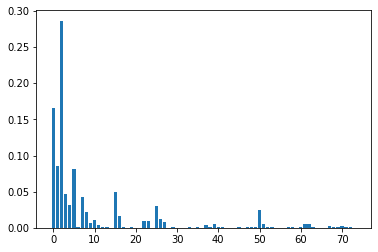

In [28]:
# get importance
importance = rnd_clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

f1 Score 0.008629989212513484

Irrelevant Documents Detected (True Negatives):  35413
Irrelevant Documents Incorrectly Detected (False Positives):  0
Relevant Documents Missed (False Negatives):  2757
Relevant Documents Detected (True Positives):  12
Total Relevant Documents:  2769


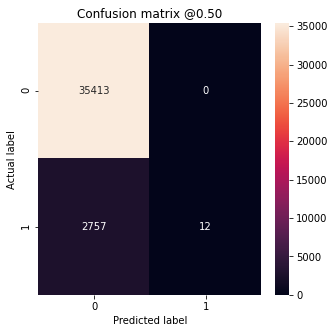

In [29]:
train_predictions_baseline = rnd_clf.predict(train_features)
test_predictions_baseline = rnd_clf.predict(test_features)

plot_cm(test_labels, test_predictions_baseline)

In [30]:
test_predictions_baseline = rnd_clf.predict(test)
test_predictions_baseline = test_predictions_baseline.round(0)
test_predictions_baseline = test_predictions_baseline.astype(int)
test_predictions_baseline

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
predictions_baseline= pd.DataFrame(test_predictions_baseline)
predictions_baseline['Id'] = predictions_baseline.index
predictions_baseline.rename(columns={ predictions_baseline.columns[0]: "psrel" }, inplace = True)
predictions_baseline = predictions_baseline[['Id','psrel']]
predictions_baseline

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [32]:
predictions_baseline['psrel'].value_counts()

0    5000
Name: psrel, dtype: int64

In [33]:
predictions_baseline.to_csv('Random Forest colab predictions.csv', index=False)

Data is still currently too skewed for standard machine learning model to accurately predict true positives. Will use large batch sizes for neural network training to try and ensure some positive values are included per batch, as well as other methods detailed below

### Three Layer Model Baseline

In [34]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# I've replaced val_auc for val_tp for monitor to see if getting more true positives will improve performance

#### Three Layer Model function

In [35]:
# Three Layer Learning Model function
def build_three_layer_model(n_hidden=3, n_neurons=30, learning_rate=3e-4, metrics=METRICS, output_bias=None, input_shape=train_features.shape[1:]):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(RegularizedDense(n_neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=0.3)),
    model.add(keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias))

    optimizer = keras.optimizers.Nadam(lr=learning_rate)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

    return model

In [36]:
# Create a default three layer model using the build_three_layer_model function

three_layer_keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_three_layer_model)

three_layer_model = build_three_layer_model()
three_layer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                2250      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                9

In [37]:
# Create onecycle for models
onecycle = OneCycleScheduler(math.ceil(len(train_labels) / BATCH_SIZE) * EPOCHS, max_rate=0.05)

Test run to compare predictions on train set vs actual values (naive predictions)

In [38]:
three_layer_model.predict(train_features[:10])

array([[0.67217886],
       [0.39560595],
       [0.71323913],
       [0.349617  ],
       [0.58257073],
       [0.5081256 ],
       [0.4015894 ],
       [0.5711932 ],
       [0.13566387],
       [0.57438475]], dtype=float32)

In [39]:
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Every prediction was wrong so we'll try some methods to improve this

#### Adjusting bias

Set correct initial bias to stop the algorithm from overfitting on the 0's

In [40]:
# Current Loss

results = three_layer_model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 9.1608


In [41]:
# What Loss should be, derived from equations
initial_bias = np.log([pos/neg])
initial_bias

array([-2.7612479])

In [42]:
pos/total

0.059454545454545454

In [43]:
three_layer_model = build_three_layer_model(output_bias=initial_bias)
three_layer_model.predict(train_features[:10])

array([[0.01054955],
       [0.0975346 ],
       [0.24057657],
       [0.03990099],
       [0.02031282],
       [0.15542495],
       [0.11674848],
       [0.02283013],
       [0.22398913],
       [0.02466205]], dtype=float32)

In [44]:
# As a result the initial loss is much less reducng the time needed for the neural network to initialise

results = three_layer_model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 8.9536


To make the various training runs more comparable, keep the initial model's weights in a checkpoint file, and load them into each model before training.

In [45]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
three_layer_model.save_weights(initial_weights)

Before moving on, confirm quick that the careful bias initialisation actually helped.

Train the model for 20 epochs, with and without this careful initialisation, and compare the losses:

In [46]:
# Without bias initialisation

three_layer_model = build_three_layer_model()
three_layer_model.load_weights(initial_weights)
three_layer_model.layers[-1].bias.assign([0.0])
zero_bias_history = three_layer_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [47]:
# With bias initialisation

three_layer_model = build_three_layer_model()
three_layer_model.load_weights(initial_weights)
careful_bias_history = three_layer_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

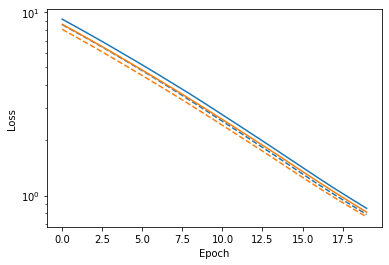

In [48]:
plot_loss(zero_bias_history, "Zero Bias", 0) #blue
plot_loss(careful_bias_history, "Careful Bias", 1) #orange

#### Train a model with adjusted biases

In [49]:
three_layer_model = build_three_layer_model()
three_layer_model.load_weights(initial_weights)
baseline_history = three_layer_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
60/60 [==============================] - 6s 41ms/step - loss: 8.8022 - tp: 127.7869 - fp: 2551.2131 - tn: 84669.8033 - fn: 6627.6393 - accuracy: 0.9042 - precision: 0.0471 - recall: 0.0173 - auc: 0.5607 - val_loss: 8.0627 - val_tp: 5.0000 - val_fp: 132.0000 - val_tn: 28207.0000 - val_fn: 2201.0000 - val_accuracy: 0.9236 - val_precision: 0.0365 - val_recall: 0.0023 - val_auc: 0.5702
Epoch 2/100
60/60 [==============================] - 1s 21ms/step - loss: 7.8997 - tp: 92.5082 - fp: 1605.9836 - tn: 57292.0984 - fn: 4440.8525 - accuracy: 0.9032 - precision: 0.0538 - recall: 0.0209 - auc: 0.5368 - val_loss: 7.2086 - val_tp: 3.0000 - val_fp: 31.0000 - val_tn: 28308.0000 - val_fn: 2203.0000 - val_accuracy: 0.9269 - val_precision: 0.0882 - val_recall: 0.0014 - val_auc: 0.5847
Epoch 3/100
60/60 [==============================] - 1s 21ms/step - loss: 7.0584 - tp: 52.4098 - fp: 1057.6557 - tn: 57810.6066 - fn: 4510.7705 - accuracy: 0.9118 - precision: 0.0441 - recall: 0.0109 - auc: 0

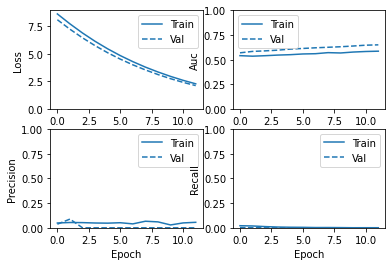

In [50]:
# produce plots of model's accuracy and loss on the training and validation set - also includes some other metrics
plot_metrics(baseline_history)

loss :  7.207339286804199
tp :  2.0
fp :  32.0
tn :  35381.0
fn :  2767.0
accuracy :  0.9266932010650635
precision :  0.05882352963089943
recall :  0.0007222823915071785
auc :  0.599455714225769

f1 Score 0.0014270424545130217

Irrelevant Documents Detected (True Negatives):  35381
Irrelevant Documents Incorrectly Detected (False Positives):  32
Relevant Documents Missed (False Negatives):  2767
Relevant Documents Detected (True Positives):  2
Total Relevant Documents:  2769


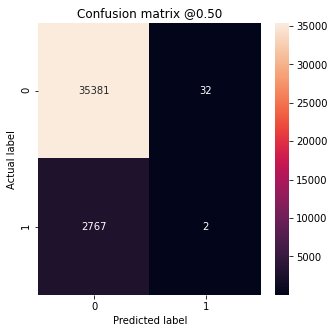

In [51]:
train_predictions_baseline = three_layer_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = three_layer_model.predict(test_features, batch_size=BATCH_SIZE)

# Print out scores for test values and confusion matrix

baseline_results = three_layer_model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(three_layer_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)



In [52]:
(three_layer_model.metrics_names[0], baseline_results[0])

('loss', 7.207339286804199)

In [53]:
pred_labels = three_layer_model.predict(test_features)
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

tl_bias = {'Model': 'Adjusted Bias Three Layer Model',
                'Loss': baseline_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

tl_bias

{'Accuracy': 0.9266932062228275,
 'F1 Score': 0.0014270424545130217,
 'Loss': 7.207339286804199,
 'Model': 'Adjusted Bias Three Layer Model',
 'Precision': 0.058823529411764705,
 'Recall': 0.0007222824124232575}

In [54]:
!mkdir -p saved_model
three_layer_model.save('saved_model/three_layer_adjusted_bias_model')

INFO:tensorflow:Assets written to: saved_model/three_layer_adjusted_bias_model/assets


If the model had predicted everything perfectly, this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few irrelevant documents that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives.

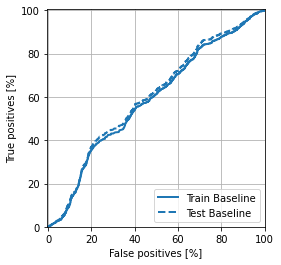

In [55]:
# Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.
 
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Tweaking Class Weights

The goal is to identify relevant documents, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [56]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.53
Weight for class 1: 8.41


#### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Nadam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [57]:
weighted_three_layer_model = build_three_layer_model()
weighted_three_layer_model.load_weights(initial_weights)

weighted_history = weighted_three_layer_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 

Epoch 1/100
60/60 [==============================] - 6s 38ms/step - loss: 10.1757 - tp: 177.4262 - fp: 2758.2787 - tn: 91537.1803 - fn: 7140.5574 - accuracy: 0.9051 - precision: 0.0574 - recall: 0.0213 - auc: 0.5643 - val_loss: 8.2662 - val_tp: 10.0000 - val_fp: 213.0000 - val_tn: 28126.0000 - val_fn: 2196.0000 - val_accuracy: 0.9211 - val_precision: 0.0448 - val_recall: 0.0045 - val_auc: 0.6387
Epoch 2/100
60/60 [==============================] - 1s 22ms/step - loss: 9.2813 - tp: 420.4590 - fp: 3786.3770 - tn: 55077.0164 - fn: 4147.5902 - accuracy: 0.8778 - precision: 0.1013 - recall: 0.0876 - auc: 0.6005 - val_loss: 7.5952 - val_tp: 14.0000 - val_fp: 334.0000 - val_tn: 28005.0000 - val_fn: 2192.0000 - val_accuracy: 0.9173 - val_precision: 0.0402 - val_recall: 0.0063 - val_auc: 0.6662
Epoch 3/100
60/60 [==============================] - 1s 22ms/step - loss: 8.4462 - tp: 719.1639 - fp: 5734.3607 - tn: 53126.8033 - fn: 3851.1148 - accuracy: 0.8506 - precision: 0.1106 - recall: 0.1529 - 

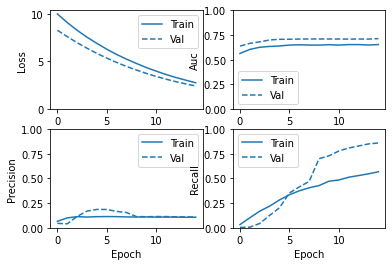

In [58]:
plot_metrics(weighted_history)

In [59]:
train_predictions_weighted = weighted_three_layer_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_three_layer_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  5.842850685119629
tp :  598.0
fp :  2415.0
tn :  32998.0
fn :  2171.0
accuracy :  0.879891037940979
precision :  0.19847328960895538
recall :  0.21596243977546692
auc :  0.7148546576499939

f1 Score 0.20684884123140782

Irrelevant Documents Detected (True Negatives):  32998
Irrelevant Documents Incorrectly Detected (False Positives):  2415
Relevant Documents Missed (False Negatives):  2171
Relevant Documents Detected (True Positives):  598
Total Relevant Documents:  2769


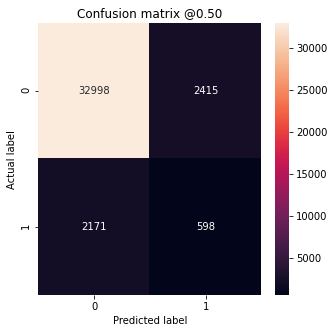

In [60]:
weighted_results = weighted_three_layer_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_three_layer_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [61]:
pred_labels = weighted_three_layer_model.predict(test_features)
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

tl_wt = {'Model': 'Adjusted Weights Three Layer Model',
                'Loss': weighted_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

tl_wt

{'Accuracy': 0.879891048137866,
 'F1 Score': 0.20684884123140782,
 'Loss': 5.842850685119629,
 'Model': 'Adjusted Weights Three Layer Model',
 'Precision': 0.1984732824427481,
 'Recall': 0.215962441314554}

In [62]:
test_predictions = weighted_three_layer_model.predict(test)

In [63]:
test_predictions = test_predictions.round(0)
test_predictions = test_predictions.astype(int)
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [64]:
predictions= pd.DataFrame(test_predictions)
predictions['Id'] = predictions.index
predictions.rename(columns={ predictions.columns[0]: "psrel" }, inplace = True)
predictions = predictions[['Id','psrel']]
predictions

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,1
4996,4996,0
4997,4997,0
4998,4998,0


In [65]:
predictions['psrel'].value_counts()

0    4746
1     254
Name: psrel, dtype: int64

In [66]:
predictions.to_csv('adjusted class weights colab predictions class weights.csv', index=False)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall.

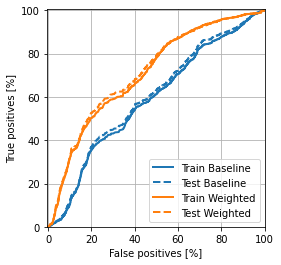

In [67]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [68]:
!mkdir -p saved_model
weighted_three_layer_model.save('saved_model/weighted_three_layer_model')

INFO:tensorflow:Assets written to: saved_model/weighted_three_layer_model/assets


#### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class. This helps the model to recognise what a relevant document looks like

In [69]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [70]:
# Use Numpy to generate new 'relevant' samples
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(113413, 74)

In [71]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(226826, 74)

In [72]:
# Use tf.data to merge positive and negative dataframes
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [73]:
# Each dataset provides (feature, label) pairs:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 2.32929311  2.51087592  5.          0.51727633 -0.47625619  0.82598882
 -0.10486708 -0.45005468 -0.54074682 -0.31429512 -0.43021835 -0.16238623
 -0.07054355 -0.06773495 -0.02789539 -0.98312632  1.99529576 -0.07453437
 -0.06581815 -0.12406205 -0.02622954 -0.04671064  3.97857554 -3.89759248
 -0.01279535  1.36770329 -0.26416726 -0.30694531 -0.02833277 -0.05745534
 -0.02494845 -0.04740941 -0.01341999 -0.05991292 -0.01716789 -0.04835387
 -0.02715082 -0.07364086 -0.08439168 -0.1045075  -0.07205113 -0.10621496
 -0.06971856 -0.03851793 -0.05615015 -0.0697778  -0.01311139 -0.0812866
 -0.03263657 -0.10187453 -1.10266791 -0.1595229  -0.12012619 -0.06606855
 -0.04801256 -0.05051674 -0.05533757 -0.05723985 -0.11061984 -0.07019115
 -0.06656657  3.68508249 -0.26404314 -0.13659859 -0.06493429 -0.01832173
 -0.06606855 -0.24421992 -0.12480815 -0.11952881 -0.14739695 -0.09456912
 -0.09722043 -0.05600327]

Label:  1


In [74]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [75]:
# To use this dataset, you'll need the number of steps per epoch. Define as number of batches to see each value of 1 once
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

31.0

#### Train a Model with Oversampled Data

Training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.

In [76]:
resampled_three_layer_model = build_three_layer_model()
resampled_three_layer_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_three_layer_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_three_layer_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
31/31 [==============================] - 6s 78ms/step - loss: 9.4670 - tp: 10106.5312 - fp: 10711.9375 - tn: 41445.8125 - fn: 9645.7188 - accuracy: 0.7313 - precision: 0.4641 - recall: 0.4898 - auc: 0.7002 - val_loss: 9.1020 - val_tp: 1515.0000 - val_fp: 16955.0000 - val_tn: 11384.0000 - val_fn: 691.0000 - val_accuracy: 0.4223 - val_precision: 0.0820 - val_recall: 0.6868 - val_auc: 0.5785
Epoch 2/100
31/31 [==============================] - 1s 40ms/step - loss: 9.0037 - tp: 9713.4375 - fp: 8416.3125 - tn: 8508.2812 - fn: 7089.9688 - accuracy: 0.5413 - precision: 0.5378 - recall: 0.5792 - auc: 0.5469 - val_loss: 8.6214 - val_tp: 1613.0000 - val_fp: 16979.0000 - val_tn: 11360.0000 - val_fn: 593.0000 - val_accuracy: 0.4247 - val_precision: 0.0868 - val_recall: 0.7312 - val_auc: 0.5995
Epoch 3/100
31/31 [==============================] - 1s 38ms/step - loss: 8.5252 - tp: 9864.5938 - fp: 8250.5000 - tn: 8630.8750 - fn: 6982.0312 - accuracy: 0.5493 - precision: 0.5444 - recall: 0

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

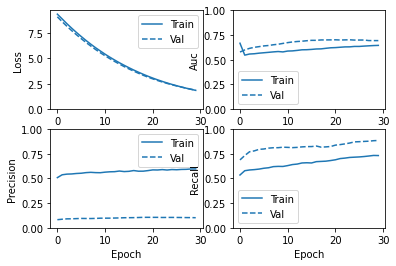

In [77]:
plot_metrics(resampled_history)

# This model seems to have performed the best by far

In [78]:
!mkdir -p saved_model
resampled_three_layer_model.save('saved_model/resampled_three_layer_model')

INFO:tensorflow:Assets written to: saved_model/resampled_three_layer_model/assets


In [79]:
train_predictions_resampled = resampled_three_layer_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_three_layer_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  3.154636859893799
tp :  2295.0
fp :  19090.0
tn :  16323.0
fn :  474.0
accuracy :  0.48761194944381714
precision :  0.107318215072155
recall :  0.8288190960884094
auc :  0.7059766054153442

f1 Score 0.19003063674753665

Irrelevant Documents Detected (True Negatives):  16323
Irrelevant Documents Incorrectly Detected (False Positives):  19090
Relevant Documents Missed (False Negatives):  474
Relevant Documents Detected (True Positives):  2295
Total Relevant Documents:  2769


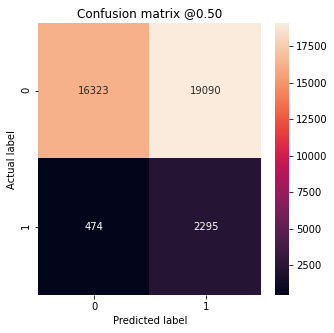

In [80]:
resampled_results = resampled_three_layer_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_three_layer_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [81]:
pred_labels = resampled_three_layer_model.predict(test_features)
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

tl_resampled = {'Model': 'Resampled Three Layer Model',
                'Loss': resampled_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

tl_resampled

{'Accuracy': 0.48761196375255356,
 'F1 Score': 0.19003063674753662,
 'Loss': 3.154636859893799,
 'Model': 'Resampled Three Layer Model',
 'Precision': 0.10731821370119242,
 'Recall': 0.828819068255688}

In [82]:
test_predictions_baseline = resampled_three_layer_model.predict(test)

In [83]:
test_predictions_baseline = test_predictions_baseline.round(0)
test_predictions_baseline = test_predictions_baseline.astype(int)
test_predictions_baseline

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [84]:
predictions_baseline= pd.DataFrame(test_predictions_baseline)
predictions_baseline['Id'] = predictions_baseline.index
predictions_baseline.rename(columns={ predictions_baseline.columns[0]: "psrel" }, inplace = True)
predictions_baseline = predictions_baseline[['Id','psrel']]
predictions_baseline

,Id,psrel
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
4995,4995,1
4996,4996,0
4997,4997,0
4998,4998,0


In [85]:
predictions_baseline['psrel'].value_counts()

0    3620
1    1380
Name: psrel, dtype: int64

In [86]:
predictions_baseline.to_csv('Resampled colab predictions.csv', index=False)

In [87]:
test_predictions_baseline = resampled_three_layer_model.predict(test_features, batch_size=BATCH_SIZE)

#### Final Evaluation

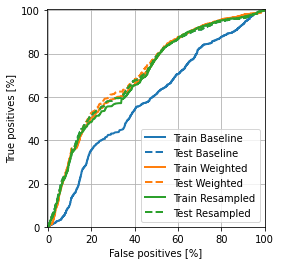

In [88]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')


In [89]:
keras.backend.clear_session()

#### Predictions

In [90]:
weighted_three_layer_model = tf.keras.models.load_model('saved_model/weighted_three_layer_model')


In [91]:
test_predictions = weighted_three_layer_model.predict(test)

In [92]:
test_predictions = test_predictions.round(0)
test_predictions = test_predictions.astype(int)
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [93]:
predictions_baseline= pd.DataFrame(test_predictions)
predictions_baseline['Id'] = predictions_baseline.index
predictions_baseline.rename(columns={ predictions_baseline.columns[0]: "psrel" }, inplace = True)
predictions_baseline = predictions_baseline[['Id','psrel']]

In [94]:
predictions_baseline['psrel'].value_counts()

0    4746
1     254
Name: psrel, dtype: int64

In [95]:
# create output file
predictions_baseline.to_csv('three-layer predictions.csv', index=False)

### Random Forest with Updated Class Weights

In [96]:
wt_rnd_clf = RandomForestClassifier(criterion = "gini", 
                                 n_estimators=200, 
                                 max_leaf_nodes=100, 
                                 min_samples_leaf=1, 
                                 max_features="sqrt",
                                 class_weight=class_weight, 
                                 n_jobs=-1)

In [97]:
wt_rnd_clf.fit(train_features, train_labels)

pred_labels = wt_rnd_clf.predict(test_features)

scores = cross_validate(wt_rnd_clf, train_features, train_labels,
                        scoring=("accuracy","precision","recall","f1"),cv=10)

wt_rnd = {'Model': 'Weighted Random Forest',
                'Loss': 0,
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

wt_rnd

{'Accuracy': 0.6841967419202766,
 'F1 Score': 0.2886135693215339,
 'Loss': 0,
 'Model': 'Weighted Random Forest',
 'Precision': 0.17248430999224315,
 'Recall': 0.883351390393644}

f1 Score 0.2886135693215339

Irrelevant Documents Detected (True Negatives):  23678
Irrelevant Documents Incorrectly Detected (False Positives):  11735
Relevant Documents Missed (False Negatives):  323
Relevant Documents Detected (True Positives):  2446
Total Relevant Documents:  2769


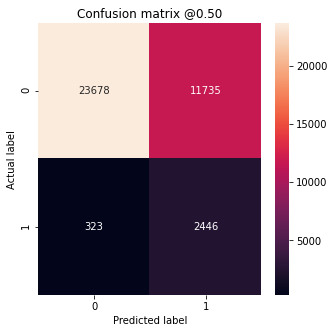

In [98]:
train_predictions_wt_rnd_clf = wt_rnd_clf.predict(train_features)
test_predictions_wt_rnd_clf = wt_rnd_clf.predict(test_features)

plot_cm(test_labels, test_predictions_wt_rnd_clf)

In [99]:
test_predictions_wt_rnd_clf = wt_rnd_clf.predict(test)
test_predictions_wt_rnd_clf = test_predictions_wt_rnd_clf.round(0)
test_predictions_wt_rnd_clf = test_predictions_wt_rnd_clf.astype(int)
test_predictions_wt_rnd_clf

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
predictions_wt_rnd_clf= pd.DataFrame(test_predictions_wt_rnd_clf)
predictions_wt_rnd_clf['Id'] = predictions_wt_rnd_clf.index
predictions_wt_rnd_clf.rename(columns={ predictions_wt_rnd_clf.columns[0]: "psrel" }, inplace = True)
predictions_wt_rnd_clf = predictions_wt_rnd_clf[['Id','psrel']]
predictions_wt_rnd_clf

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [101]:
predictions_wt_rnd_clf['psrel'].value_counts()

0    4247
1     753
Name: psrel, dtype: int64

In [102]:
predictions_wt_rnd_clf.to_csv('Reweighted Random Forest colab predictions.csv', index=False)

Baseline Model also performs much better with updated weights

### Deep Network Model

#### Dense Deep Model Function

In [163]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [164]:
def build_dense_deep(n_hidden=5, n_neurons=30, learning_rate=3e-4, metrics=METRICS, output_bias=None, input_shape=train_features.shape[1:]):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.models.Sequential()
  model.add(keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(n_hidden):
    model.add(RegularizedDense(n_neurons))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(rate=0.3))
  model.add(keras.layers.Dense(1, activation="sigmoid", bias_initializer=output_bias))
 
  optimizer = keras.optimizers.Nadam(lr=learning_rate)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
  return model

In [165]:
# Create a default dense deep model using the build_dense_deep function

dense_deep_keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_dense_deep)

dense_deep_model = build_dense_deep()
dense_deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 30)                2250      
_________________________________________________________________
batch_normalization_10 (Batc (None, 30)                120       
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 30)                930       
_________________________________________________________________
batch_normalization_11 (Batc (None, 30)                120       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 30)               

#### With Class Weights

In [166]:
# Find initial weights
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
dense_deep_model.save_weights(initial_weights)

In [167]:
# Load in previously calculated weights

dense_deep_model.load_weights(initial_weights)

dense_deep_history = dense_deep_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight) 

Epoch 1/100
60/60 [==============================] - 8s 48ms/step - loss: 14.6395 - tp: 2891.7377 - fp: 30173.2787 - tn: 64110.6230 - fn: 4437.8033 - accuracy: 0.6413 - precision: 0.0878 - recall: 0.4255 - auc: 0.5396 - val_loss: 13.1118 - val_tp: 22.0000 - val_fp: 348.0000 - val_tn: 27991.0000 - val_fn: 2184.0000 - val_accuracy: 0.9171 - val_precision: 0.0595 - val_recall: 0.0100 - val_auc: 0.5993
Epoch 2/100
60/60 [==============================] - 2s 29ms/step - loss: 13.3975 - tp: 1161.4098 - fp: 12591.7213 - tn: 46312.7213 - fn: 3365.5902 - accuracy: 0.7508 - precision: 0.0831 - recall: 0.2507 - auc: 0.5541 - val_loss: 12.0768 - val_tp: 1212.0000 - val_fp: 10088.0000 - val_tn: 18251.0000 - val_fn: 994.0000 - val_accuracy: 0.6372 - val_precision: 0.1073 - val_recall: 0.5494 - val_auc: 0.6258
Epoch 3/100
60/60 [==============================] - 2s 29ms/step - loss: 12.2641 - tp: 1387.0000 - fp: 14273.9836 - tn: 44565.9180 - fn: 3204.5410 - accuracy: 0.7263 - precision: 0.0892 - reca

##### Evaluation

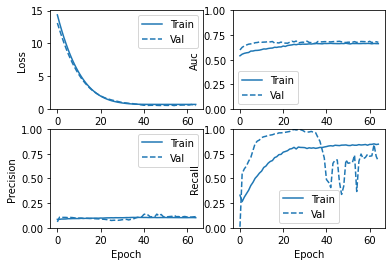

In [168]:
plot_metrics(dense_deep_history)

In [169]:
train_predictions_dense_deep_model = dense_deep_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_dense_deep_model = dense_deep_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5520079731941223
tp :  1045.0
fp :  6986.0
tn :  28427.0
fn :  1724.0
accuracy :  0.7718820571899414
precision :  0.13012078404426575
recall :  0.37739256024360657
auc :  0.6796947121620178

f1 Score 0.1935185185185185

Irrelevant Documents Detected (True Negatives):  28427
Irrelevant Documents Incorrectly Detected (False Positives):  6986
Relevant Documents Missed (False Negatives):  1724
Relevant Documents Detected (True Positives):  1045
Total Relevant Documents:  2769


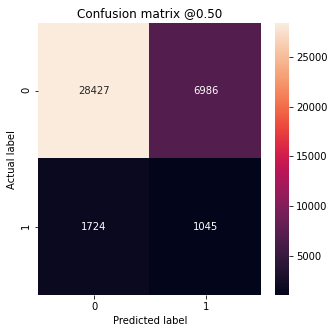

In [170]:
dense_deep_results = dense_deep_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(dense_deep_model.metrics_names, dense_deep_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_dense_deep_model)

In [171]:
pred_labels = dense_deep_model.predict(test_features)
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

dense_deep = {'Model': 'Dense Deep Model',
                'Loss': dense_deep_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

dense_deep

{'Accuracy': 0.7718820386569588,
 'F1 Score': 0.19351851851851853,
 'Loss': 0.5520079731941223,
 'Model': 'Dense Deep Model',
 'Precision': 0.13012078196986676,
 'Recall': 0.37739256049115205}

##### Predictions

In [172]:
test_predictions = dense_deep_model.predict(test)

In [173]:
test_predictions = test_predictions.round(0)
test_predictions = test_predictions.astype(int)
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [174]:
predictions= pd.DataFrame(test_predictions)
predictions['Id'] = predictions.index
predictions.rename(columns={ predictions.columns[0]: "psrel" }, inplace = True)
predictions = predictions[['Id','psrel']]
predictions

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
4995,4995,1
4996,4996,0
4997,4997,0
4998,4998,0


In [175]:
predictions['psrel'].value_counts()

0    4092
1     908
Name: psrel, dtype: int64

In [176]:
predictions.to_csv('dense deep colab predictions.csv', index=False)

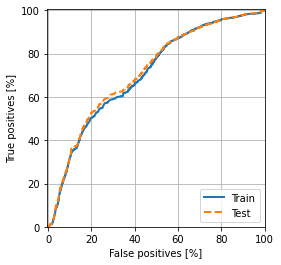

In [177]:
plot_roc("Train", train_labels, train_predictions_weighted, color=colors[0])
plot_roc("Test", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

#### With Resampled Dataset

In [178]:
resampled_dense_deep_model = build_dense_deep()
resampled_dense_deep_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_dense_deep_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

In [179]:
resampled_history = resampled_dense_deep_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
31/31 [==============================] - 8s 80ms/step - loss: 14.5230 - tp: 10481.0000 - fp: 15677.1875 - tn: 36720.0000 - fn: 9031.8125 - accuracy: 0.6667 - precision: 0.3752 - recall: 0.5262 - auc: 0.6396 - val_loss: 13.8054 - val_tp: 1218.0000 - val_fp: 12585.0000 - val_tn: 15754.0000 - val_fn: 988.0000 - val_accuracy: 0.5556 - val_precision: 0.0882 - val_recall: 0.5521 - val_auc: 0.5677
Epoch 2/100
31/31 [==============================] - 1s 45ms/step - loss: 13.8466 - tp: 9399.3750 - fp: 8523.5938 - tn: 8481.3750 - fn: 7323.6562 - accuracy: 0.5302 - precision: 0.5238 - recall: 0.5627 - auc: 0.5424 - val_loss: 13.2283 - val_tp: 1591.0000 - val_fp: 15517.0000 - val_tn: 12822.0000 - val_fn: 615.0000 - val_accuracy: 0.4719 - val_precision: 0.0930 - val_recall: 0.7212 - val_auc: 0.5813
Epoch 3/100
31/31 [==============================] - 1s 45ms/step - loss: 13.1656 - tp: 9399.7812 - fp: 8433.2188 - tn: 8519.5312 - fn: 7375.4688 - accuracy: 0.5309 - precision: 0.5264 - reca

##### Evaluation

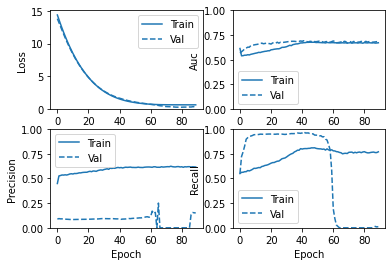

In [180]:
plot_metrics(resampled_history)

In [181]:
!mkdir -p saved_model
resampled_dense_deep_model.save('saved_model/resampled_dense_deep_model')

INFO:tensorflow:Assets written to: saved_model/resampled_dense_deep_model/assets


In [182]:
dd_train_predictions_resampled = resampled_dense_deep_model.predict(train_features, batch_size=BATCH_SIZE)
dd_test_predictions_resampled = resampled_dense_deep_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.2981646656990051
tp :  0.0
fp :  0.0
tn :  35413.0
fn :  2769.0
accuracy :  0.9274789094924927
precision :  0.0
recall :  0.0
auc :  0.6781696081161499

f1 Score 0.0

Irrelevant Documents Detected (True Negatives):  35413
Irrelevant Documents Incorrectly Detected (False Positives):  0
Relevant Documents Missed (False Negatives):  2769
Relevant Documents Detected (True Positives):  0
Total Relevant Documents:  2769


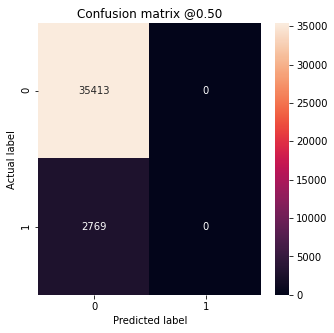

In [183]:
resampled_results = resampled_dense_deep_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_dense_deep_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, dd_test_predictions_resampled)

In [184]:
pred_labels = resampled_dense_deep_model.predict(test_features)
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

deep_dense_resampled = {'Model': 'Resampled Dense Deep Layer Model',
                'Loss': resampled_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

deep_dense_resampled

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9274789167670631,
 'F1 Score': 0.0,
 'Loss': 0.2981646656990051,
 'Model': 'Resampled Dense Deep Layer Model',
 'Precision': 0.0,
 'Recall': 0.0}

##### Predictions

In [185]:
test_predictions = resampled_dense_deep_model.predict(test)

In [186]:
test_predictions = test_predictions.round(0)
test_predictions = test_predictions.astype(int)
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [187]:
predictions= pd.DataFrame(test_predictions)
predictions['Id'] = predictions.index
predictions.rename(columns={ predictions.columns[0]: "psrel" }, inplace = True)
predictions = predictions[['Id','psrel']]
predictions

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [188]:
predictions['psrel'].value_counts()

0    5000
Name: psrel, dtype: int64

In [189]:
predictions.to_csv('resampled dense deep colab predictions.csv', index=False)

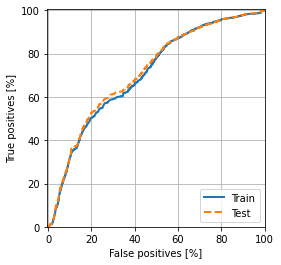

In [190]:
plot_roc("Train", train_labels, train_predictions_weighted, color=colors[0])
plot_roc("Test", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

### Wide and Deep Model

In [191]:
input_wide = keras.layers.Input(shape=[23], name="wide_input")
input_deep = keras.layers.Input(shape=[74], name="deep_input")

In [192]:
wd_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

#### Wide and Deep Model Class

In [193]:
# Wide and Deep Learning Model function
class WideAndDeepModel(keras.Model):
  def __init__(self, n_neurons=30, activation="elu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = RegularizedDense(n_neurons)
    self.hidden2 = RegularizedDense(n_neurons)
    self.main_output = keras.layers.Dense(1, activation="sigmoid")

  def call(self, inputs):
    input_wide, input_deep = inputs
    hidden1 = self.hidden1(input_deep)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_wide, hidden2])
    main_output = self.main_output(concat)

    return main_output

In [194]:
wide_train_features.shape

(122179, 23)

In [195]:
deep_train_features.shape

(122179, 74)

In [196]:
wd_model = WideAndDeepModel(n_neurons=30, activation="elu")

wd_model.compile(loss=["binary_crossentropy"], optimizer=keras.optimizers.Nadam(lr=3e-4), metrics="accuracy")

wd_model_history = wd_model.fit([wide_train_features, deep_train_features], train_labels, 
                    epochs=40,
                    validation_data=([wide_val_features, deep_val_features], val_labels),
                    callbacks=[wd_early_stopping],
                    verbose=1)

total_loss = wd_model.evaluate((wide_test_features, deep_test_features),
                                                 test_labels)
print(total_loss)

Epoch 1/40
3819/3819 [==============================] - 8s 2ms/step - loss: 2.3788 - accuracy: 0.8894 - val_loss: 0.2620 - val_accuracy: 0.9278
Epoch 2/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2635 - accuracy: 0.9271 - val_loss: 0.2615 - val_accuracy: 0.9278
Epoch 3/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2609 - accuracy: 0.9278 - val_loss: 0.2605 - val_accuracy: 0.9278
Epoch 4/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2612 - accuracy: 0.9275 - val_loss: 0.2608 - val_accuracy: 0.9278
Epoch 5/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2608 - accuracy: 0.9276 - val_loss: 0.2605 - val_accuracy: 0.9278
Epoch 6/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2592 - accuracy: 0.9282 - val_loss: 0.2604 - val_accuracy: 0.9278
Epoch 7/40
3819/3819 [==============================] - 7s 2ms/step - loss: 0.2608 - accuracy: 0.9276 - val_loss: 0.2604 - val_accuracy:

##### Evaluation

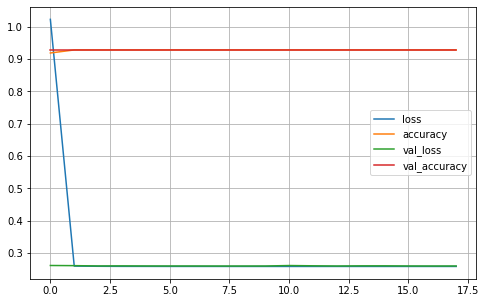

In [197]:
pd.DataFrame(wd_model_history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.show()

In [198]:
train_predictions_wd_model = wd_model.predict((wide_train_features, deep_train_features))
test_predictions_wd_model = wd_model.predict((wide_test_features, deep_test_features))

loss :  0.26101353764533997
accuracy :  0.9274789094924927

f1 Score 0.0

Irrelevant Documents Detected (True Negatives):  35413
Irrelevant Documents Incorrectly Detected (False Positives):  0
Relevant Documents Missed (False Negatives):  2769
Relevant Documents Detected (True Positives):  0
Total Relevant Documents:  2769


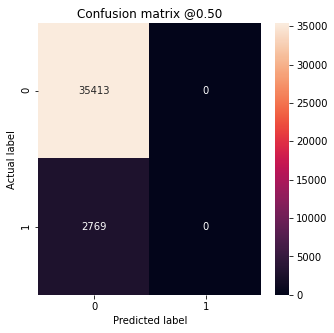

In [199]:
wd_results = wd_model.evaluate((wide_test_features, deep_test_features), test_labels, verbose=0)
for name, value in zip(wd_model.metrics_names, wd_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_wd_model)

In [200]:
pred_labels = wd_model.predict((wide_test_features, deep_test_features))
pred_labels = pred_labels.round(0)
pred_labels = pred_labels.astype(int)

wd = {'Model': 'Wide and Deep Model',
                'Loss': wd_results[0],
                'Accuracy': accuracy_score(test_labels, pred_labels),
                'Precision': precision_score(test_labels, pred_labels),
                'Recall': recall_score(test_labels, pred_labels),
                'F1 Score': f1_score(test_labels, pred_labels)}

wd

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9274789167670631,
 'F1 Score': 0.0,
 'Loss': 0.26101353764533997,
 'Model': 'Wide and Deep Model',
 'Precision': 0.0,
 'Recall': 0.0}

##### Predictions

In [201]:
test_predictions = wd_model.predict((wide_test, deep_test))
test_predictions

array([[0.04131371],
       [0.04296234],
       [0.03876209],
       ...,
       [0.08579043],
       [0.0406076 ],
       [0.04273307]], dtype=float32)

In [202]:
test_predictions = test_predictions.round(0)
test_predictions = test_predictions.astype(int)
test_predictions

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [203]:
predictions= pd.DataFrame(test_predictions)
predictions['Id'] = predictions.index
predictions.rename(columns={ predictions.columns[0]: "psrel" }, inplace = True)
predictions = predictions[['Id','psrel']]
predictions

,Id,psrel
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,0
4998,4998,0


In [204]:
predictions['psrel'].value_counts()

0    5000
Name: psrel, dtype: int64

In [205]:
predictions.to_csv('wide and deep colab predictions.csv', index=False)

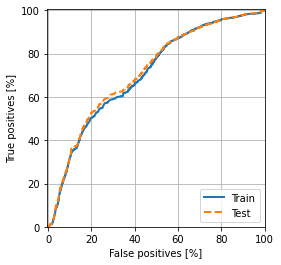

In [206]:
plot_roc("Train", train_labels, train_predictions_weighted, color=colors[0])
plot_roc("Test", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

## Any Additional Analysis
- Add in any additional analysis etc that you performed here.

In [207]:
### Create table of testing performance

model_dict = [unwt_rnd, wt_rnd, tl_bias, tl_wt, tl_resampled, dense_deep, deep_dense_resampled, wd]


In [208]:
model_df = pd.DataFrame(model_dict)
model_df

,Model,Loss,Accuracy,Precision,Recall,F1 Score
0,Unweighted Random Forest,0.000000,0.927793,1.000000,0.004334,0.008630
1,Weighted Random Forest,0.000000,0.684197,0.172484,0.883351,0.288614
2,Adjusted Bias Three Layer Model,7.207339,0.926693,0.058824,0.000722,0.001427
3,Adjusted Weights Three Layer Model,5.842851,0.879891,0.198473,0.215962,0.206849
4,Resampled Three Layer Model,3.154637,0.487612,0.107318,0.828819,0.190031
5,Dense Deep Model,0.552008,0.771882,0.130121,0.377393,0.193519
6,Resampled Dense Deep Layer Model,0.298165,0.927479,0.000000,0.000000,0.000000
7,Wide and Deep Model,0.261014,0.927479,0.000000,0.000000,0.000000


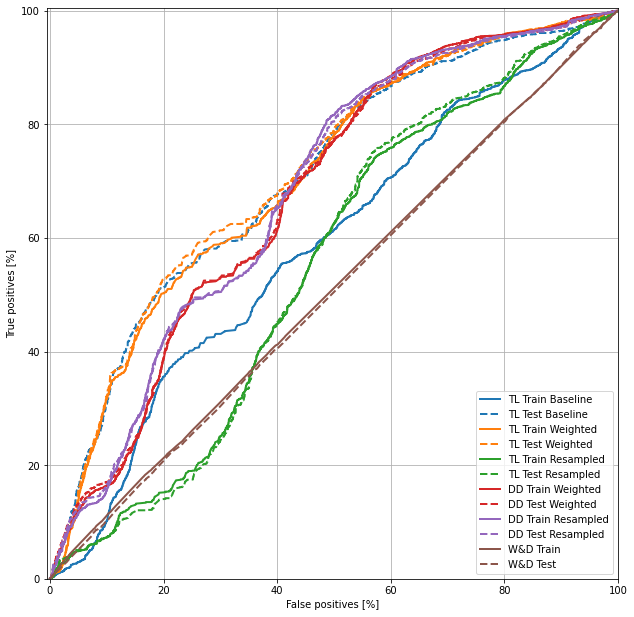

In [209]:
plot_roc("TL Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("TL Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("TL Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("TL Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("TL Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("TL Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')

plot_roc("DD Train Weighted", train_labels, train_predictions_dense_deep_model, color=colors[3])
plot_roc("DD Test Weighted", test_labels, test_predictions_dense_deep_model, color=colors[3], linestyle='--')

plot_roc("DD Train Resampled", train_labels, dd_train_predictions_resampled, color=colors[4])
plot_roc("DD Test Resampled", test_labels, dd_test_predictions_resampled, color=colors[4], linestyle='--')

plot_roc("W&D Train", train_labels, train_predictions_wd_model, color=colors[5])
plot_roc("W&D Test", test_labels, test_predictions_wd_model, color=colors[5], linestyle='--')

plt.legend(loc='lower right')


fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('graph.png', dpi=100)